<a href="https://colab.research.google.com/github/ShreyaVerma7/Algo/blob/master/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import math
import numpy as np
import seaborn as sns
from sklearn import preprocessing

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y.%m.%d %H:%M:%S')

In [30]:
#from google.colab import files
#uploaded = files.upload()
fl = ['AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv','USDCHF_4 Hours_Ask_2003.05.04_2020.03.12.csv','EURUSD_4 Hours_Ask_2003.05.04_2020.03.12.csv','GBPUSD_4 Hours_Ask_2003.05.04_2020.03.12.csv','NZDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv','USDCAD_4 Hours_Ask_2003.08.03_2020.03.12.csv']

for i in range(len(fl)):
  print(i+1,'. ',fl[i])

print('Enter file number for analysis:')
x = int(input())

df_aud = pd.read_csv(fl[x-1], parse_dates=['Time (UTC)'], date_parser=dateparse)


1 .  AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv
2 .  USDCHF_4 Hours_Ask_2003.05.04_2020.03.12.csv
3 .  EURUSD_4 Hours_Ask_2003.05.04_2020.03.12.csv
4 .  GBPUSD_4 Hours_Ask_2003.05.04_2020.03.12.csv
5 .  NZDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv
6 .  USDCAD_4 Hours_Ask_2003.08.03_2020.03.12.csv
Enter file number for analysis:
1


In [ ]:
#d_aud = df_aud.copy()

In [31]:
df_aud['Time (UTC)'] = pd.to_datetime(df_aud['Time (UTC)']) 
df_aud = df_aud.set_index('Time (UTC)')

In [32]:
df_aud['Volatility'] = df_aud['High']/df_aud['Low']
df_aud['Volatility'] = np.log(df_aud['Volatility'])
df_aud['Adj_Volume'] = df_aud['Volume ']/(df_aud['Volume '].rolling(10).mean())
df_aud['R_Close'] = df_aud['Close'] - df_aud['Close'].shift(1)
df_aud['R_Open'] = df_aud['Open'] - df_aud['Open'].shift(1)
df_aud['R_High'] = df_aud['High'] - df_aud['High'].shift(1)
df_aud['R_Low'] = df_aud['Low'] - df_aud['Low'].shift(1)
df_aud['H-L'] = df_aud['High'] - df_aud['Low']
df_aud['O-L'] = df_aud['Open'] - df_aud['Low']
df_aud['C-L'] = df_aud['Close']- df_aud['Low']
df_aud['H-O'] = df_aud['High'] - df_aud['Open']
df_aud['H-C'] = df_aud['High'] - df_aud['Close']
df_aud['O-C'] = df_aud['Open'] - df_aud['Close']
df_aud['(C-O)/(H-L)'] = (-df_aud['O-C']) / df_aud['H-L']
df_aud['(O-L)/(C)'] = df_aud['O-L'] / df_aud['Close']
df_aud['(O-H)/(C)'] = df_aud['H-O'] / df_aud['Close']
df_aud.dropna(inplace = True)
df_aud = df_aud.drop(['Volume '],axis=1)
df_aud.head()

,Open,High,Low,Close,Volatility,Adj_Volume,R_Close,R_Open,R_High,R_Low,H-L,O-L,C-L,H-O,H-C,O-C,(C-O)/(H-L),(O-L)/(C),(O-H)/(C)
Time (UTC),,,,,,,,,,,,,,,,,,,
2003-08-05 09:00:00,0.64273,0.64366,0.64054,0.64291,0.004859,1.206673,-0.00009,-0.00431,-0.00359,-0.00143,0.00312,0.00219,0.00237,0.00093,0.00075,-0.00018,0.057692,0.003406,0.001447
2003-08-05 13:00:00,0.64295,0.64644,0.64175,0.64510,0.007282,0.738269,0.00219,0.00022,0.00278,0.00121,0.00469,0.00120,0.00335,0.00349,0.00134,-0.00215,0.458422,0.001860,0.005410
2003-08-05 17:00:00,0.64485,0.64705,0.64465,0.64635,0.003716,0.484466,0.00125,0.00190,0.00061,0.00290,0.00240,0.00020,0.00170,0.00220,0.00070,-0.00150,0.625000,0.000309,0.003404
2003-08-05 21:00:00,0.64681,0.64867,0.64526,0.64794,0.005271,0.627086,0.00159,0.00196,0.00162,0.00061,0.00341,0.00155,0.00268,0.00186,0.00073,-0.00113,0.331378,0.002392,0.002871
2003-08-06 01:00:00,0.64775,0.65062,0.64758,0.64965,0.004683,0.917345,0.00171,0.00094,0.00195,0.00232,0.00304,0.00017,0.00207,0.00287,0.00097,-0.00190,0.625000,0.000262,0.004418


In [33]:
print(df_aud.info())
print()
print(df_aud.describe())
print()
print(df_aud.median()-df_aud.mean())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25799 entries, 2003-08-05 09:00:00 to 2020-03-12 21:00:00
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         25799 non-null  float64
 1   High         25799 non-null  float64
 2   Low          25799 non-null  float64
 3   Close        25799 non-null  float64
 4   Volatility   25799 non-null  float64
 5   Adj_Volume   25799 non-null  float64
 6   R_Close      25799 non-null  float64
 7   R_Open       25799 non-null  float64
 8   R_High       25799 non-null  float64
 9   R_Low        25799 non-null  float64
 10  H-L          25799 non-null  float64
 11  O-L          25799 non-null  float64
 12  C-L          25799 non-null  float64
 13  H-O          25799 non-null  float64
 14  H-C          25799 non-null  float64
 15  O-C          25799 non-null  float64
 16  (C-O)/(H-L)  25799 non-null  float64
 17  (O-L)/(C)    25799 non-null  float64
 18  (O-H)/(C)  

In [34]:
#Test for staionarity
def test_stationarity(timeseries):
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_aud['R_Close'])

Results of dickey fuller test
Test Statistics                  -21.947394
p-value                            0.000000
No. of lags used                  49.000000
Number of observations used    25749.000000
critical value (1%)               -3.430604
critical value (5%)               -2.861652
critical value (10%)              -2.566830
dtype: float64


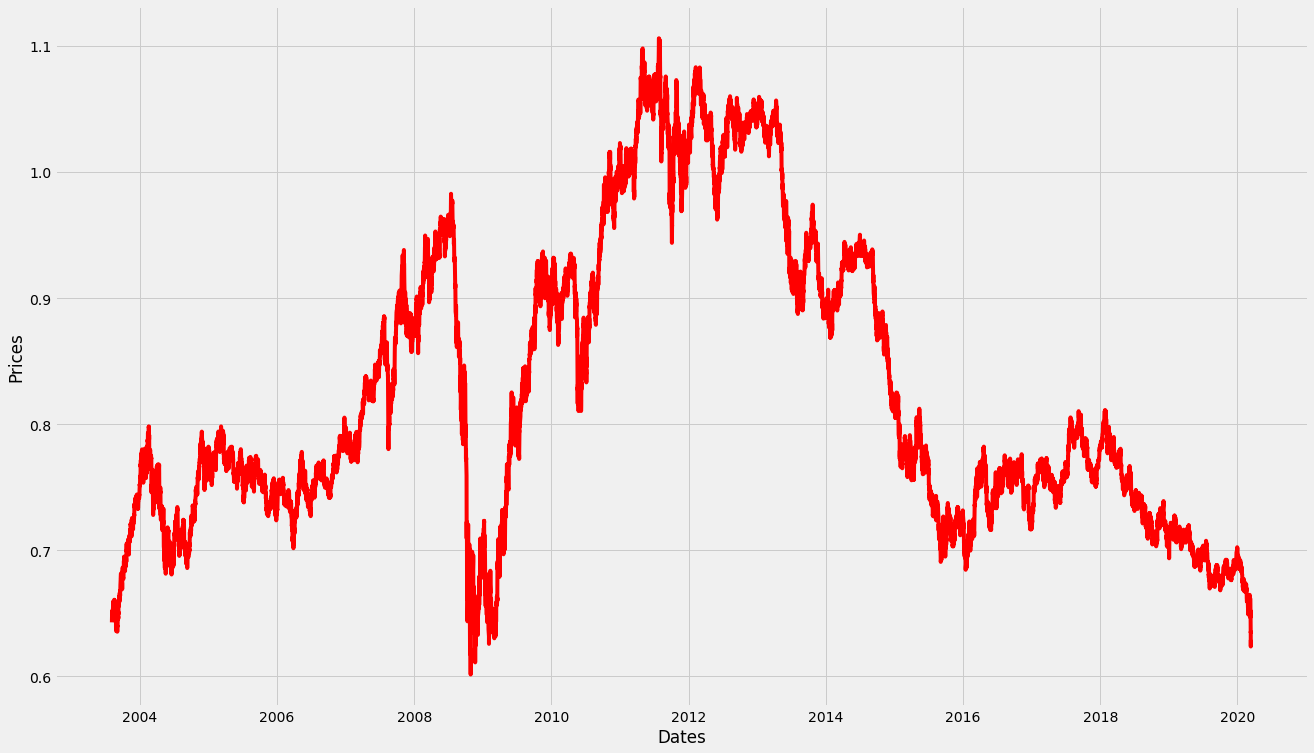

In [50]:
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_aud['Close'],color='red')
#plt.plot(df_aud['Open'],color='blue')
#plt.plot(df_aud['High'],color='green')
#plt.plot(df_aud['Low'],color='black')
#plt.plot(df_aud['Adj_Volume'],color='red')

plt.show()

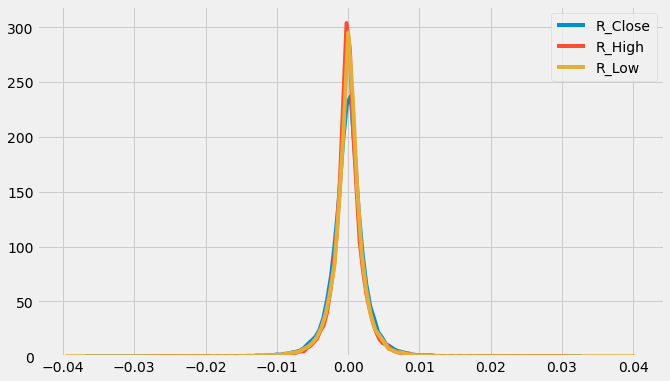

In [9]:
dist1 = sns.kdeplot(df_aud['R_Close'])
dist2 = sns.kdeplot(df_aud['R_High'])
dist3 = sns.kdeplot(df_aud['R_Low'])


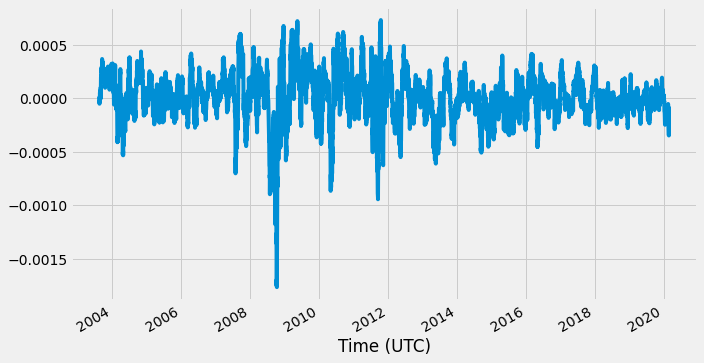

In [10]:
result = seasonal_decompose(df_aud['R_Close'], model='additive',freq = 132).trend
fig = plt.figure()  
fig = result.plot()  

<Figure size 1440x864 with 0 Axes>

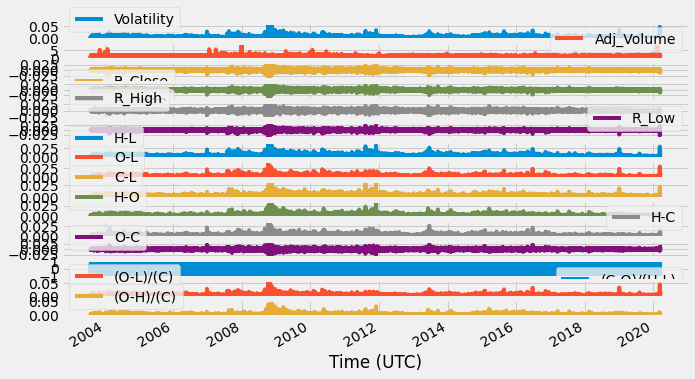

<Figure size 1440x864 with 0 Axes>

In [16]:
figure = df_aud.plot(subplots=True)
plt.figure(figsize=(20,12))

In [35]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [51]:
future_target = 100
past_history = 300
STEP = 6
TRAIN_SPLIT = int(0.9*len(df_aud))
dataset = df_aud.values
#scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [52]:
x_train, y_train = multivariate_data(dataset, dataset[:,1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP)

x_test, y_test = multivariate_data(dataset, dataset[:,1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP)

print ('Single window of past history : {}'.format(x_train[0].shape))
print ('\n Target value to predict : {}'.format(y_train[0].shape))

Single window of past history : (50, 19)

 Target value to predict : (100,)


In [53]:
import tensorflow
train_data_multi = tensorflow.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_multi = train_data_multi.cache().shuffle(10000).batch(256).repeat()

val_data_multi = tensorflow.data.Dataset.from_tensor_slices((x_test, y_test))
val_data_multi = val_data_multi.batch(256).repeat()

In [54]:
def create_time_steps(length):
  return list(range(-length, 0))


In [55]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

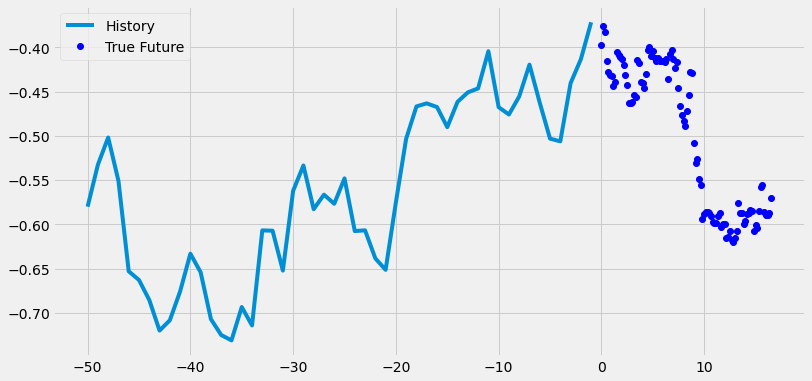

In [56]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [57]:
import tensorflow as tf

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.25))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(100))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='binary_crossentropy',metrics=['accuracy'])
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            21504     
_________________________________________________________________
dropout (Dropout)            (None, 50, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 100)               3300      
Total params: 37,220
Trainable params: 37,220
Non-trainable params: 0
_________________________________________________________________


In [58]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 100)


In [65]:
for i in range(100):
  multi_step_history = multi_step_model.fit(train_data_multi, epochs=i,
                                          steps_per_epoch=20,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
  multi_step_model.reset_states()

20/20 [==============================] - 4s 186ms/step - loss: -8.4984 - accuracy: 0.0363 - val_loss: -19.0785 - val_accuracy: 0.0114
Epoch 23/35
20/20 [==============================] - 4s 182ms/step - loss: -8.2418 - accuracy: 0.0398 - val_loss: -19.0785 - val_accuracy: 0.0099
Epoch 24/35
20/20 [==============================] - 4s 183ms/step - loss: -7.8527 - accuracy: 0.0385 - val_loss: -19.0785 - val_accuracy: 0.0113
Epoch 25/35
20/20 [==============================] - 4s 185ms/step - loss: -7.9636 - accuracy: 0.0428 - val_loss: -19.0785 - val_accuracy: 0.0077
Epoch 26/35
 9/20 [============>.................] - ETA: 1s - loss: -8.4695 - accuracy: 0.0417

KeyboardInterrupt: ignored

In [60]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


NameError: ignored

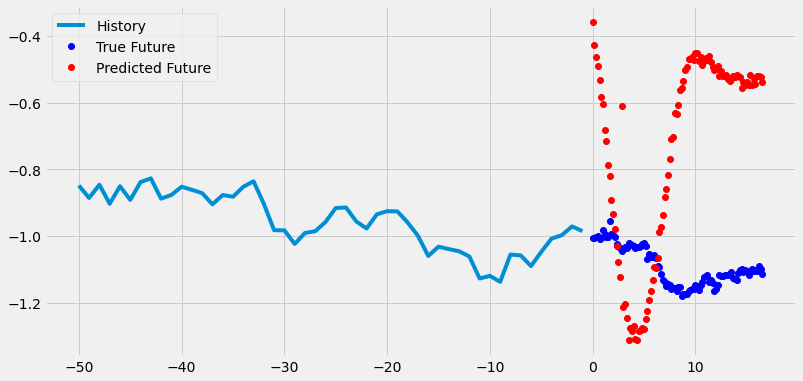

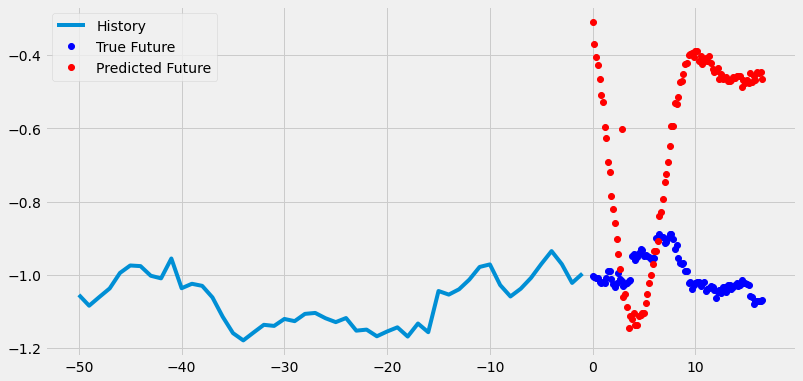

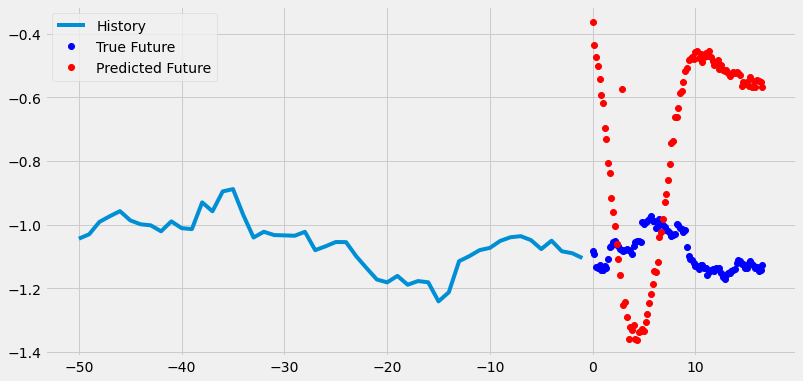

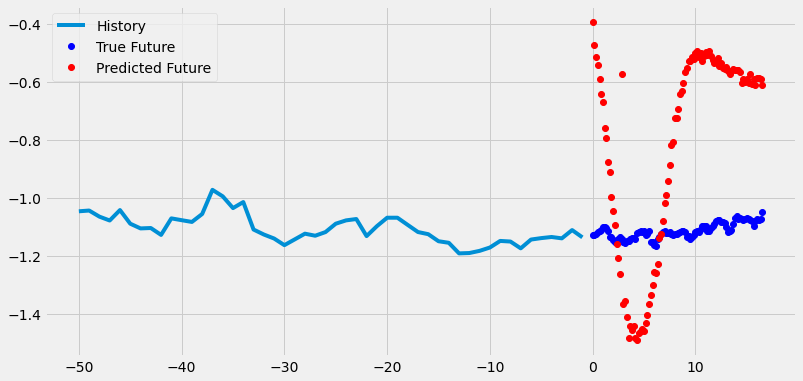

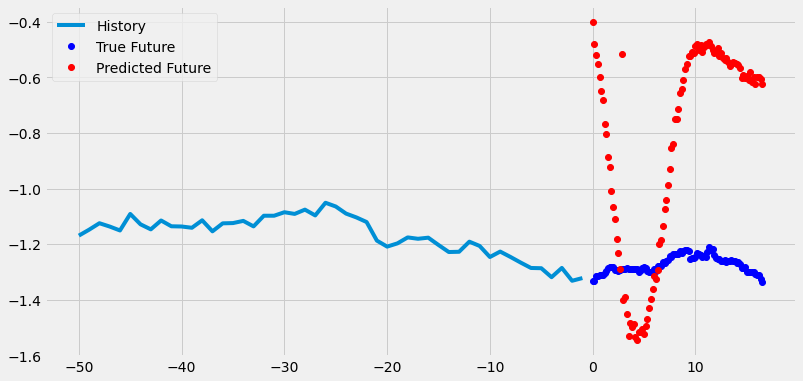

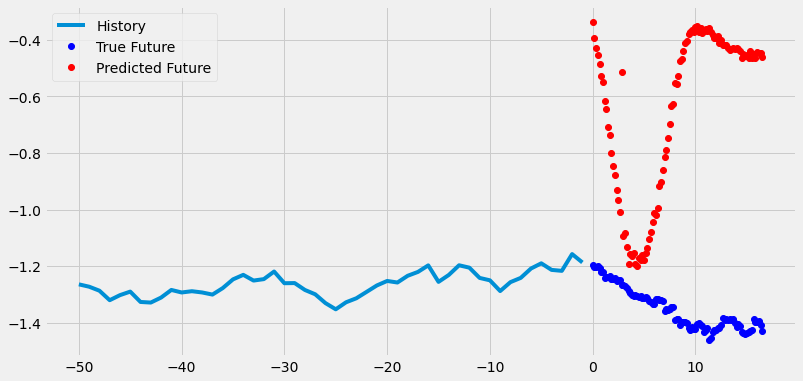

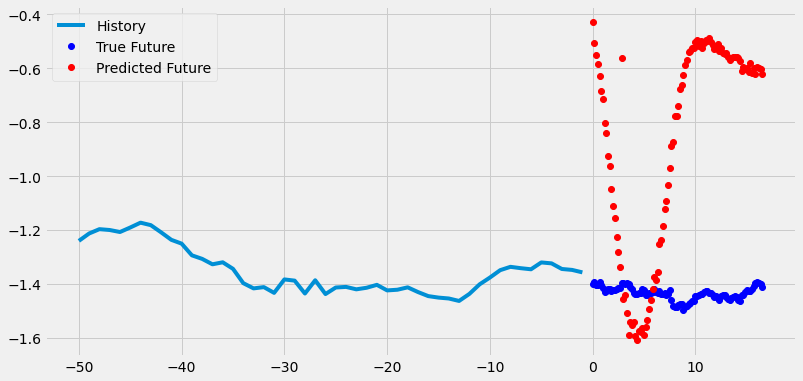

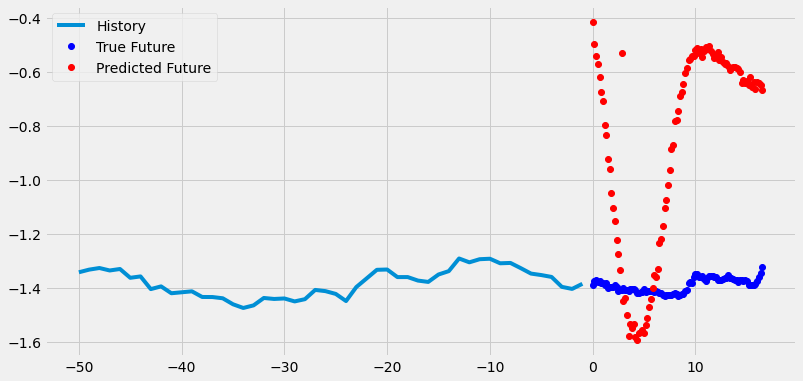

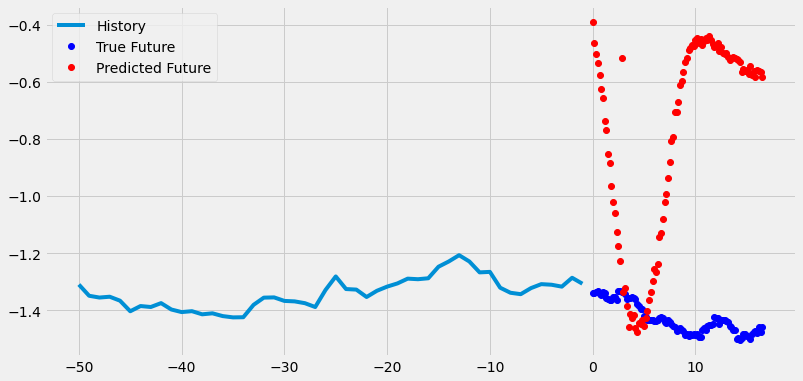

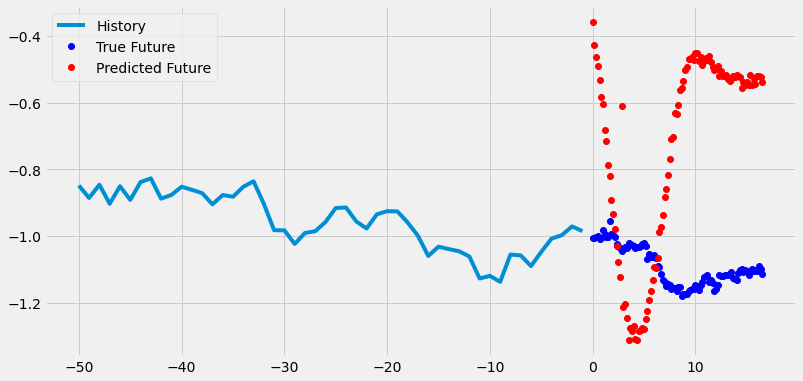

In [61]:
for x, y in val_data_multi.take(10):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])